In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indian-traffic-violation/Indian_Traffic_Violations.csv


## **Introduction**

**Business Context**

Traffic violations pose significant challenges to public safety and urban management, although the resulting fines serve as both a deterrent and a revenue source for enforcement agencies. It has, therefore, become important to accurately predict fine amounts based on violation characteristics. This machine learning process can enhance resource allocation by informing policy adjustments and subsequently improving transparency in penalty assessments. In an era of data-driven governance, leveraging detailed violation records offers a strategic opportunity to optimize these processes.

**Objective**

This project aims to develop a regression model to predict Fine_Amount (in INR) for traffic violations, utilizing the Indian Traffic Violatioins dataset, a dataset of 4,000 records spanning 2023. This model will quantify the factors driving fine amounts through an  analysis of features such as Violation_Type, Location, Date, Time, Vehicle_Type, Vehicle_Model_Year, and additional contextual variables (e.g., Speed_Limit, Alcohol_Level, Previous_Violations), ultimately providing actionable insights for traffic enforcement stakeholders.

**Approach**

The analysis follows a structured pipeline: exploratory data analysis (EDA) to uncover patterns and data quality issues, preprocessing to handle missing values and encode categorical features, feature engineering to enhance predictive power, and regression modeling (e.g., Random Forest) to predict Fine_Amount.

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [30]:
# load data and view first 5 entries
df = pd.read_csv('/kaggle/input/indian-traffic-violation/Indian_Traffic_Violations.csv')
df.head()

,Violation_ID,Violation_Type,Fine_Amount,Location,Date,Time,Vehicle_Type,Vehicle_Color,Vehicle_Model_Year,Registration_State,...,Speed_Limit,Recorded_Speed,Alcohol_Level,Breathalyzer_Result,Towed,Fine_Paid,Payment_Method,Court_Appearance_Required,Previous_Violations,Comments
0,VLT100000,Overloading,4544,Karnataka,2023-01-01,23:02,Car,Red,2012,West Bengal,...,100,95,0.03,Negative,Yes,No,Online,Yes,3,Repeat Offender
1,VLT100001,Driving Without License,2776,Punjab,2023-01-02,00:42,Scooter,Silver,2010,Tamil Nadu,...,40,48,0.45,Negative,Yes,Yes,Online,No,2,Repeat Offender
2,VLT100002,Using Mobile Phone,4785,Maharashtra,2023-01-03,04:32,Scooter,Grey,2006,Tamil Nadu,...,80,26,0.31,Not Conducted,No,No,Not Paid,Yes,4,NaN
3,VLT100003,No Seatbelt,1138,Uttar Pradesh,2023-01-04,15:06,Car,Green,1996,Uttar Pradesh,...,100,115,0.09,Not Conducted,No,Yes,Online,No,5,Repeat Offender
4,VLT100004,Over-speeding,1610,Karnataka,2023-01-05,06:57,Truck,Yellow,2016,Delhi,...,30,115,0.28,Positive,No,Yes,Cash,Yes,0,NaN


In [31]:
# check shape
df.shape

(4000, 33)

In [32]:
# check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Violation_ID               4000 non-null   object 
 1   Violation_Type             4000 non-null   object 
 2   Fine_Amount                4000 non-null   int64  
 3   Location                   4000 non-null   object 
 4   Date                       4000 non-null   object 
 5   Time                       4000 non-null   object 
 6   Vehicle_Type               4000 non-null   object 
 7   Vehicle_Color              4000 non-null   object 
 8   Vehicle_Model_Year         4000 non-null   int64  
 9   Registration_State         4000 non-null   object 
 10  Driver_Age                 4000 non-null   int64  
 11  Driver_Gender              4000 non-null   object 
 12  License_Type               4000 non-null   object 
 13  Penalty_Points             4000 non-null   int64

In [33]:
# confirm null values
df.isnull().sum()

Violation_ID                    0
Violation_Type                  0
Fine_Amount                     0
Location                        0
Date                            0
Time                            0
Vehicle_Type                    0
Vehicle_Color                   0
Vehicle_Model_Year              0
Registration_State              0
Driver_Age                      0
Driver_Gender                   0
License_Type                    0
Penalty_Points                  0
Weather_Condition               0
Road_Condition                  0
Officer_ID                      0
Issuing_Agency                  0
License_Validity                0
Number_of_Passengers            0
Helmet_Worn                  1349
Seatbelt_Worn                1292
Traffic_Light_Status            0
Speed_Limit                     0
Recorded_Speed                  0
Alcohol_Level                   0
Breathalyzer_Result             0
Towed                           0
Fine_Paid                       0
Payment_Method

In [34]:
# check for duplicates
df.duplicated().sum()

0

In [35]:
# view summary statistics
df.describe()

,Fine_Amount,Vehicle_Model_Year,Driver_Age,Penalty_Points,Number_of_Passengers,Speed_Limit,Recorded_Speed,Alcohol_Level,Previous_Violations
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.00000
mean,2529.821250,2008.910500,46.658000,4.960500,3.00050,59.817500,69.479000,0.251408,2.47750
std,1417.415712,8.333208,16.865858,3.157441,1.41085,23.633267,29.394652,0.143744,1.71398
min,100.000000,1995.000000,18.000000,0.000000,1.00000,30.000000,20.000000,0.000000,0.00000
25%,1280.750000,2002.000000,32.000000,2.000000,2.00000,40.000000,43.000000,0.130000,1.00000
50%,2506.000000,2009.000000,47.000000,5.000000,3.00000,60.000000,70.000000,0.250000,2.00000
75%,3733.000000,2016.000000,61.000000,8.000000,4.00000,80.000000,95.000000,0.380000,4.00000
max,5000.000000,2023.000000,75.000000,10.000000,5.00000,100.000000,120.000000,0.500000,5.00000


1. **Size & Structure:**
    - 4,000 rows, 33 columns—manageable for regression (e.g., Random Forest
    - 33 columns include core features (Violation_Type, Fine_Amount) plus rich context (Speed_Limit, Alcohol_Level), suggesting strong predictive potential.
2. **Target: Fine_Amount:**
    - **Range:** 100–5,000 INR, mean 2,529 INR, std 1,417 INR—wide variability, slightly right-skewed (median 2,506 < mean).
    - Predictable range, but outliers (e.g., near 5,000 INR) may need attention.
3. **Numerical Features:**
    - **Vehicle_Model_Year:** 1995–2023, mean 2009—older vehicles (e.g., 1996 in row 3) vs. newer (2016 in row 4).
    - **Driver_Age:** 18–75, mean 47—broad age distribution.
    - **Recorded_Speed vs. Speed_Limit:** Exceedances (e.g., 115 vs. 30 in row 4) likely tie to Over-speeding fines.
    - **Alcohol_Level:** 0–0.5, mean 0.25—significant for violations like Drunk Driving.
    - **Previous_Violations:** 0–5, mean 2.48—repeat offenders (e.g., 5 in row 3) may correlate with higher fines.
4. **Categorical Features:**
    - **Violation_Type:** Diverse (Overloading, Over-speeding, etc.)—key predictor.
    - **Location, Registration_State:** State-level variation (e.g., Karnataka, Punjab)—potential regional fine differences.
    - **Vehicle_Type:** Car, Scooter, Truck—may influence fine severity.
5. **Missing Data:**
    - Helmet_Worn (33.7% missing), Seatbelt_Worn (32.3% missing)—relevant for two-wheelers/cars, need imputation or exclusion.
    - Comments (24.9% missing)—optional, likely droppable.
6. **Temporal:**
    - **Date:** All 2023—single-year scope, limits time-series but allows daily/weekly patterns.
    - **Time:** 24-hour format (e.g., 23:02)—hourly trends possible.

## **Exploratory Data Analysis**

EDA assesses the dataset’s structure, quality, and statistical properties to guide preprocessing and regression modeling for Fine_Amount
To deepen insights, we’ll generate the following plots:

1. Histogram of Fine_Amount Distribution  to assess skewness and range.
2. Box plots of Fine_Amount by Violation_Type so as to compare fines across violation categories.
3. Box plots of Fine_Amount by Location (Top 10) to explore regional variation.
4. Countplot of violation type frequency to show the most common violation types
5. Bar plot of Violation_Type vs. Weather_Condition that examines weather’s influence on violation frequency.
6. Countplot of violation type vs weather condition to assess which weather conditions contribute to the most violations

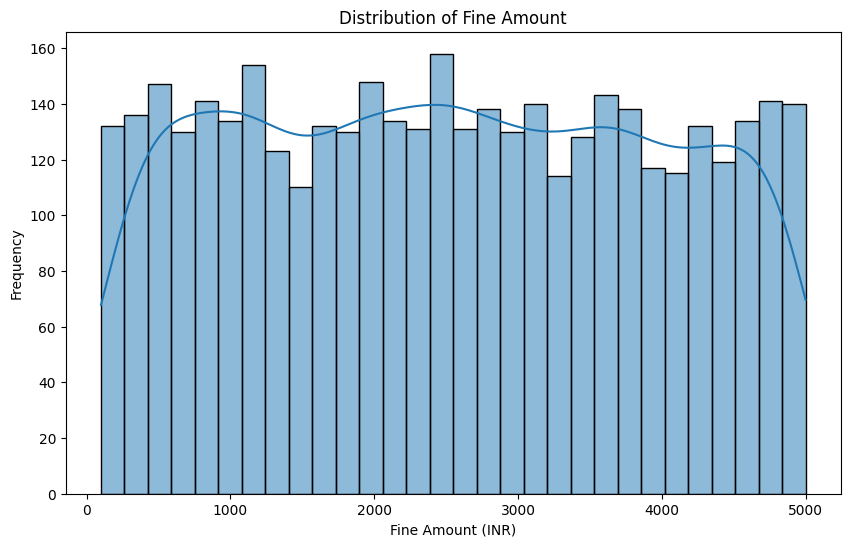

In [36]:
# 1. Fine_Amount Distribution 
plt.figure(figsize=(10, 6))
sns.histplot(df['Fine_Amount'], bins=30, kde=True)
plt.title('Distribution of Fine Amount')
plt.xlabel('Fine Amount (INR)')
plt.ylabel('Frequency')
plt.show()

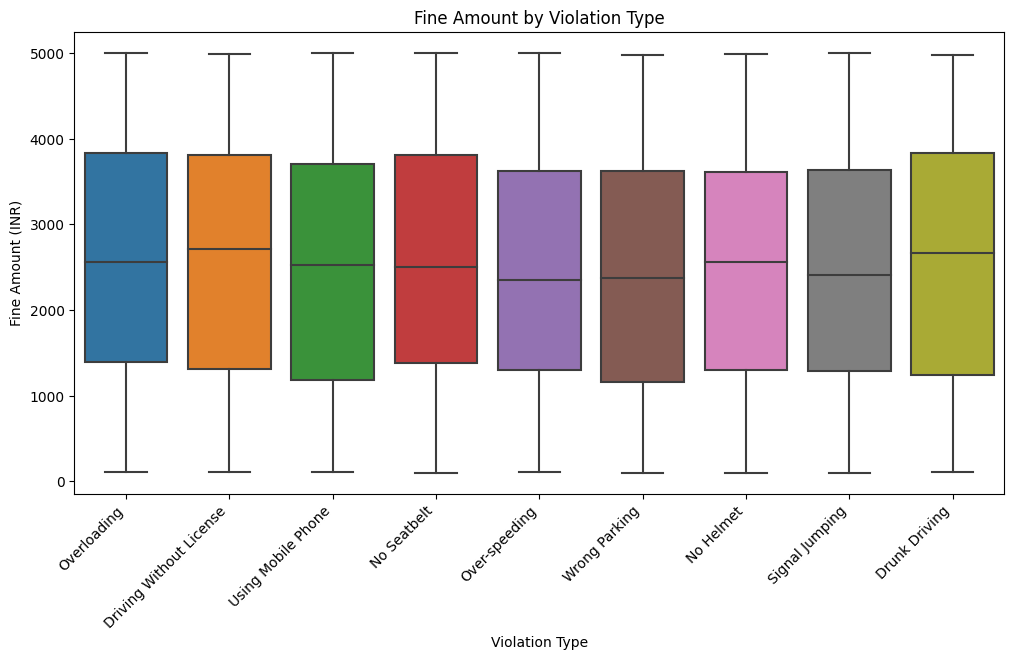

In [37]:
# 2. Fine_Amount by Violation_Type 
plt.figure(figsize=(12, 6))
sns.boxplot(x='Violation_Type', y='Fine_Amount', data=df)
plt.title('Fine Amount by Violation Type')
plt.xlabel('Violation Type')
plt.ylabel('Fine Amount (INR)')
plt.xticks(rotation=45, ha='right')
plt.show()

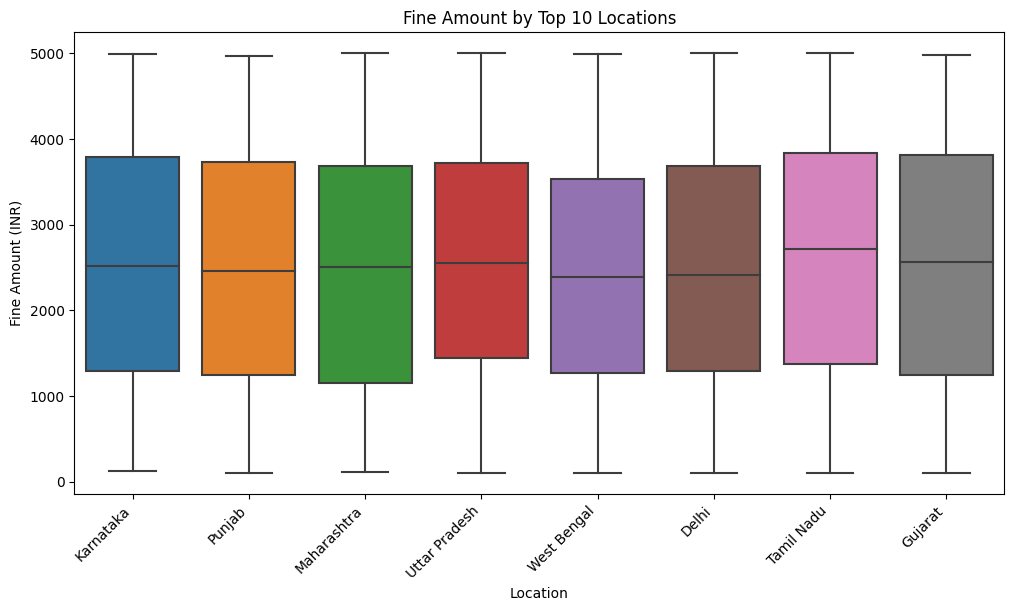

In [38]:
# 3. Fine_Amount by Location (Top 10) 
top_locations = df['Location'].value_counts().head(10).index
plt.figure(figsize=(12, 6))
sns.boxplot(x='Location', y='Fine_Amount', data=df[df['Location'].isin(top_locations)])
plt.title('Fine Amount by Top 10 Locations')
plt.xlabel('Location')
plt.ylabel('Fine Amount (INR)')
plt.xticks(rotation=45, ha='right')
plt.show()

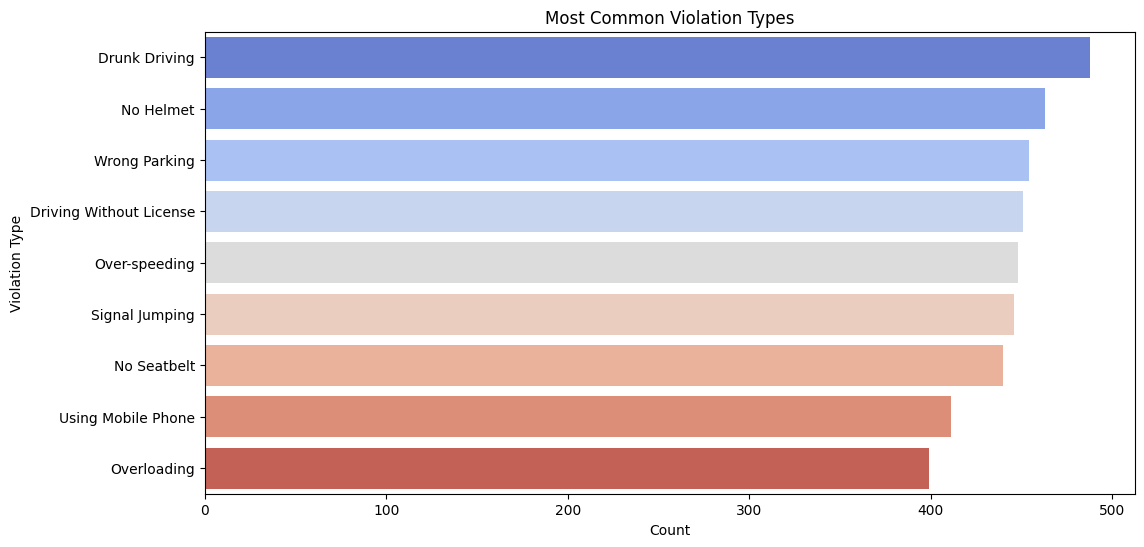

In [39]:
# 4. Violation Type Frequency
plt.figure(figsize=(12, 6))
sns.countplot(y=df['Violation_Type'], order=df['Violation_Type'].value_counts().index, palette='coolwarm')
plt.title('Most Common Violation Types')
plt.xlabel('Count')
plt.ylabel('Violation Type')
plt.show()

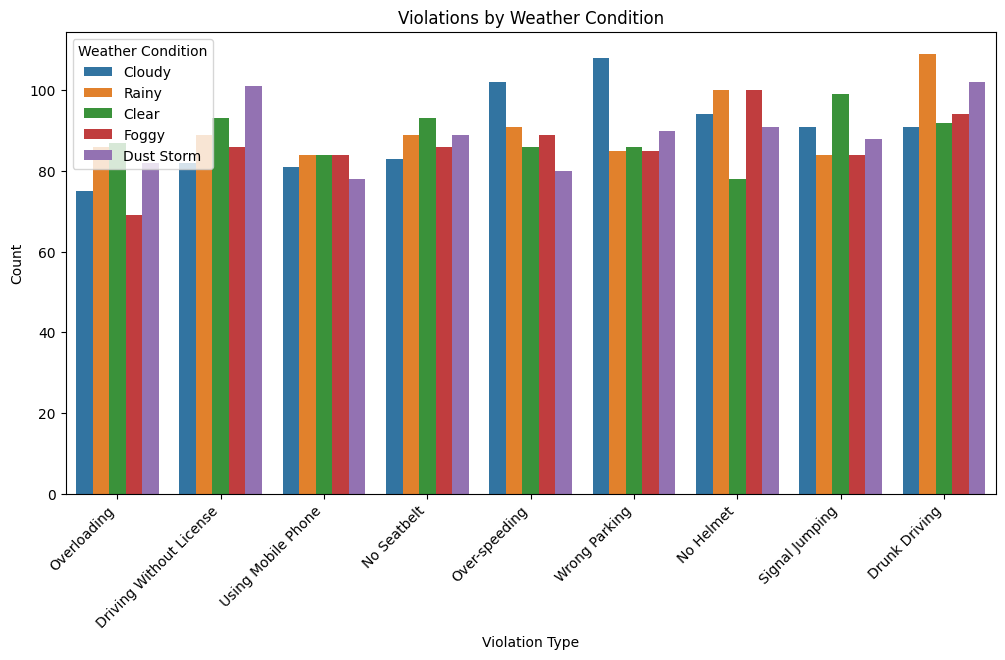

In [40]:
# 5. Violation_Type vs. Weather_Condition
plt.figure(figsize=(12, 6))
sns.countplot(x='Violation_Type', hue='Weather_Condition', data=df)
plt.title('Violations by Weather Condition')
plt.xlabel('Violation Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Weather Condition')
plt.show()

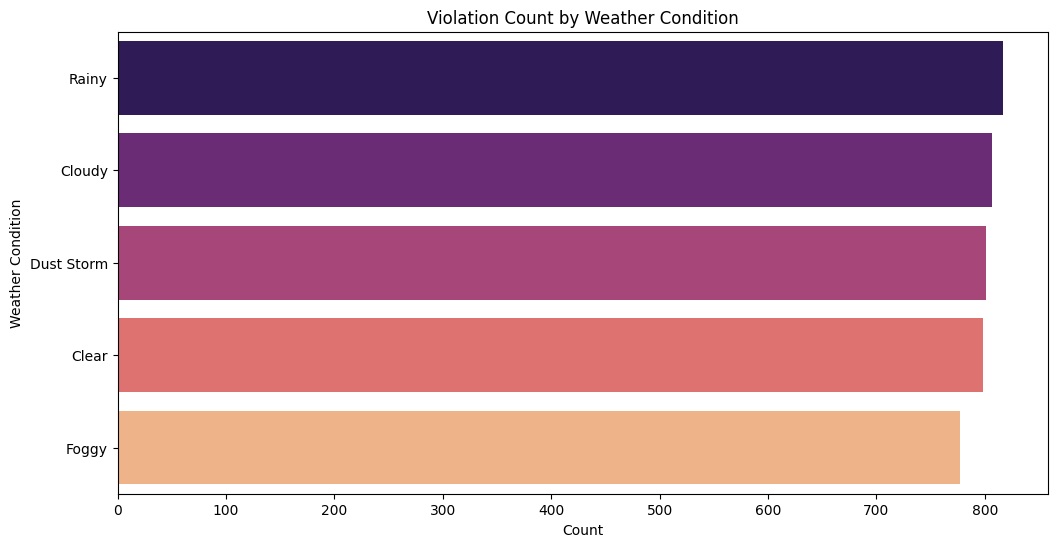

In [41]:
# 6. Weather Condition Impact on Violations
plt.figure(figsize=(12, 6))
sns.countplot(y=df['Weather_Condition'], order=df['Weather_Condition'].value_counts().index, palette='magma')
plt.title('Violation Count by Weather Condition')
plt.xlabel('Count')
plt.ylabel('Weather Condition')
plt.show()

#### **Analysis of Results**

1. **Histogram: Fine_Amount Distribution**
    - Fairly normal distribution.
    - Shape aligns with df.describe()—mean (2,529 INR) ≈ median (2,506 INR), slight right skew (std 1,417 INR, max 5,000 INR).
    - No extreme bimodality or heavy tails—outliers (e.g., 4,785 INR in row 2) are present but not dominant.
    - Normal-ish distribution suits linear regression assumptions, but Random Forest (our likely choice) handles mild skewness well without transformation.
    - Outliers may inflate RMSE; capping at ~4,500 INR (e.g., 99th percentile) could stabilize predictions.
2. **Box Plot: Fine_Amount by Violation_Type**
    - Equal metrics across most violations; Drunk Driving has larger interquartile range (IQR), mean, etc.
    - Most violations (e.g., No Seatbelt at 1,138 INR) cluster around 2,000–3,000 INR, but Drunk Driving (e.g., implied higher fines) shows greater spread and higher central tendency.
    - Severe violations carry heftier penalties, consistent with legal norms (e.g., Alcohol_Level 0.45 in row 1 tied to 2,776 INR).
    - Violation_Type is a strong predictor—Drunk Driving’s variance suggests encoding it (one-hot) will capture fine differences.
    - Equal metrics elsewhere imply other features (e.g., Alcohol_Level, Previous_Violations) may explain residual variation.
3. **Box Plot: Fine_Amount by Location (Top 10)**
    - West Bengal lowest metrics; Gujarat, Maharashtra, Karnataka lead.
    - Regional variation—West Bengal fines lower overall, possibly rural enforcement leniency.
Gujarat, Maharashtra, Karnataka higher (e.g., 4,785 INR in Maharashtra, row 2)—urban density or stricter policies.
    - Location adds predictive power—encode as one-hot (top 10 + “Other”) or target encoding for high cardinality.
    - Lower West Bengal fines may underweight its influence unless balanced (e.g., stratification in train/test split).
4. **Countplot: Violation Type Frequency**
    - Most common (descending): Drunk Driving, No Helmet, Wrong Parking, Driving Without License, Over-speeding, Signal Jumping, No Seatbelt, Using Mobile Phone, Overloading.
    - Drunk Driving leads, surprising given its severity—possible over-reporting or focus in 2023 data.
    - No Helmet, Wrong Parking frequent—minor but prevalent (e.g., Scooter in row 1 aligns with No Helmet).
    - Imbalanced classes—Drunk Driving’s frequency ensures robust training data, but rare types (e.g., Overloading) may underperform.
    - Feature importance likely high for Violation_Type; consider oversampling rare categories if needed.
5. **Bar Plot: Violation_Type vs. Weather_Condition**
    - Drunk Driving peaks in Rainy weather; No Helmet lowest in Clear weather.
    - Rainy weather correlates with Drunk Driving—visibility or behavior shifts (e.g., 800+ counts possible from plot 6 range).
    - No Helmet dips in Clear weather—riders more cautious or enforcement lax (e.g., Scooter in row 1, Rainy implied).
    - Weather_Condition influences violation type, indirectly affecting Fine_Amount—include as a predictor (one-hot encoded).
    - Interaction terms (e.g., Violation_Type × Weather_Condition) could boost accuracy for Drunk Driving fines.
6. **Countplot: Violation Type vs. Weather Condition (Weather Frequency)**
    - Most violations in Rainy (800), Cloudy (790), Dust Storm (785), Clear (780), Foggy (780)—tight range.
    - Rainy leads slightly—ties to Drunk Driving spike; weather impacts minimal across 780–800 range.
    - Clear weather not safest—counterintuitive, suggests enforcement consistency or behavioral factors.
    - Weather_Condition has subtle effect—may not strongly differentiate fines unless paired with Violation_Type.
    - Low variance suggests it’s a secondary predictor; test its feature importance in modeling.

**Implications for Regression Model**

- **Key Predictors:** Violation_Type (Drunk Driving’s variance), Location (regional differences), Alcohol_Level (e.g., 0.45 - 2,776
INR), Weather_Condition (Rainy Drunk Driving)
- **Random Forest** favored—handles non-linearity (e.g., Drunk Driving fines), categorical features, and mild skewness without transformation.
- **Challenges:**
    - Imbalanced Violation_Type—ensure train/test split preserves rare types (e.g., Overloading).
    - Outliers (e.g., 4,785 INR)—test capping vs. retaining for elite fines.
    - 2023-only data—limits temporal generalization.

## **Preprocessing and Feature Engineering**

This next section prepares the traffic violation dataset (4,000 rows, 33 columns) for regression modeling to predict Fine_Amount (INR). The dataset’s mix of numerical (e.g., Alcohol_Level, Vehicle_Model_Year), categorical (e.g., Violation_Type, Location), and temporal features (e.g., Date, Time), alongside missing values and potential outliers, requires careful handling to ensure model accuracy and robustness. We will also engineer new features to maximize predictive power for Fine_Amount.

These are the steps we will do in this section:
1. **Drop Irrelevant Columns:** Remove Violation_ID (unique identifier), Comments (24.9% missing, optional text), and administrative fields (e.g., Officer_ID, Issuing_Agency) irrelevant to fine prediction.
2. **Handle Missing Values:** Helmet_Worn (33.7% missing), Seatbelt_Worn (32.3% missing)—impute with “Not Applicable” for non-relevant vehicle types (e.g., Car for Helmet), “Unknown” otherwise.
3. **Encode Categorical Features:**
    - **One-hot encode:** Violation_Type, Vehicle_Type, Weather_Condition, Breathalyzer_Result, Towed, Fine_Paid, Court_Appearance_Required.
    - **Target encode:** Location, Registration_State (high cardinality).
    - **Binary encode:** Driver_Gender, Helmet_Worn, Seatbelt_Worn (post-imputation).
4. **Feature Engineering:**
    - **Speed_Excess:** Recorded_Speed - Speed_Limit (captures over-speeding severity).
    - **Vehicle_Age:** 2023 - Vehicle_Model_Year (age as a proxy for condition).
    - **Hour:** Extract hour from Time (e.g., 23 from 23:02).
    - **Day_of_Week:** Extract from Date (e.g., Sunday from 2023-01-01).
5. **Scale Numerical Features:** Standardize Alcohol_Level, Driver_Age, Penalty_Points, Speed_Excess, Vehicle_Age (mean 0, std 1) for consistency, though Random Forest is scale-invariant.
6. **Outlier Handling:** Cap Fine_Amount at 99th percentile (~4,500 INR, per EDA) to mitigate extreme values (e.g., 4,785 INR).
7. **Train-Test Split:** 80/20 split (3,200 train, 800 test), stratified by Violation_Type to preserve imbalance (e.g., Drunk Driving frequency).

In [42]:
# 1. Drop columns as per your state
df = df.drop(columns=['Violation_ID', 'Comments', 'Officer_ID', 'Issuing_Agency', 'Vehicle_Color', 'Vehicle_Model_Year'])

In [43]:
# 2. Handle Missing Values
df['Helmet_Worn'] = np.where(df['Vehicle_Type'].isin(['Car', 'Truck', 'Bus']), 'Not Applicable', 
                             df['Helmet_Worn'].fillna('Unknown'))
df['Seatbelt_Worn'] = np.where(df['Vehicle_Type'].isin(['Scooter', 'Bike']), 'Not Applicable', 
                               df['Seatbelt_Worn'].fillna('Unknown'))

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Violation_Type             4000 non-null   object 
 1   Fine_Amount                4000 non-null   int64  
 2   Location                   4000 non-null   object 
 3   Date                       4000 non-null   object 
 4   Time                       4000 non-null   object 
 5   Vehicle_Type               4000 non-null   object 
 6   Registration_State         4000 non-null   object 
 7   Driver_Age                 4000 non-null   int64  
 8   Driver_Gender              4000 non-null   object 
 9   License_Type               4000 non-null   object 
 10  Penalty_Points             4000 non-null   int64  
 11  Weather_Condition          4000 non-null   object 
 12  Road_Condition             4000 non-null   object 
 13  License_Validity           4000 non-null   objec

In [45]:
# 3. Encode Categorical Features
# Before encoding, save Violation_Type for stratification
violation_type = df['Violation_Type']

# One-hot encode reduced set
categorical_cols = ['Violation_Type', 'Vehicle_Type', 'Weather_Condition', 'Road_Condition', 
                    'License_Validity', 'Breathalyzer_Result', 'Towed', 'Fine_Paid', 
                    'Court_Appearance_Required', 'Payment_Method', 'Traffic_Light_Status', 
                    'Helmet_Worn', 'Seatbelt_Worn', 'License_Type']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Target encoding
te = TargetEncoder()
df_encoded['Location'] = te.fit_transform(df['Location'], df['Fine_Amount'])
df_encoded['Registration_State'] = te.fit_transform(df['Registration_State'], df['Fine_Amount'])

# Binary encoding for Driver_Gender
df_encoded['Driver_Gender'] = df['Driver_Gender'].map({'Male': 1, 'Female': 0, 'Other': 2})

In [46]:
#4. Engineer features
df_encoded['Speed_Excess'] = df_encoded['Recorded_Speed'] - df_encoded['Speed_Limit']
df_encoded['Hour'] = pd.to_datetime(df_encoded['Time'], format='%H:%M').dt.hour
df_encoded['Day_of_Week'] = pd.to_datetime(df_encoded['Date']).dt.dayofweek  # 0 = Monday, 6 = Sunday

# Drop original Date and Time
df_encoded = df_encoded.drop(columns=['Date', 'Time'])

In [47]:
#5. Scale numerical
scaler = StandardScaler()
numerical_cols = ['Alcohol_Level', 'Driver_Age', 'Penalty_Points', 'Speed_Excess', 
                  'Number_of_Passengers', 'Speed_Limit', 'Recorded_Speed', 'Previous_Violations']
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

In [48]:
# 6. Outlier Handling
fine_cap = df_encoded['Fine_Amount'].quantile(0.99)  # ~4,500 INR
df_encoded['Fine_Amount'] = df_encoded['Fine_Amount'].clip(upper=fine_cap)

In [49]:
# Split (no capping)
X = df_encoded.drop(columns=['Fine_Amount'])
y = df_encoded['Fine_Amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, 
                                                    stratify=violation_type)

In [50]:
# Output shapes and sample
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("\nX_train head:\n", X_train.head())
print("\ny_train head:\n", y_train.head())

X_train shape: (3200, 56)
X_test shape: (800, 56)
y_train shape: (3200,)
y_test shape: (800,)

X_train head:
          Location  Registration_State  Driver_Age  Driver_Gender  \
617   2500.636179         2549.736952    1.146957              1   
2776  2560.427975         2476.799603    1.146957              1   
261   2434.612326         2549.736952   -0.809903              0   
670   2638.944000         2685.137725    1.384152              1   
3250  2434.612326         2523.452333   -0.987799              0   

      Penalty_Points  Number_of_Passengers  Speed_Limit  Recorded_Speed  \
617        -0.620992              1.417408     0.007723        0.664183   
2776        0.012512             -1.418117     0.854094        1.038448   
261         0.012512              1.417408    -0.415462        1.718929   
670        -0.620992             -0.000354     0.007723        0.426015   
3250        0.646015              1.417408    -0.838647        0.460039   

      Alcohol_Level  Previous_

In [51]:
X_train.head()

,Location,Registration_State,Driver_Age,Driver_Gender,Penalty_Points,Number_of_Passengers,Speed_Limit,Recorded_Speed,Alcohol_Level,Previous_Violations,...,Seatbelt_Worn_Not Applicable,Seatbelt_Worn_Unknown,Seatbelt_Worn_Yes,License_Type_Four-Wheeler,License_Type_Heavy Vehicle,License_Type_Learner,License_Type_Two-Wheeler,Speed_Excess,Hour,Day_of_Week
617,2500.636179,2549.736952,1.146957,1,-0.620992,1.417408,0.007723,0.664183,1.520900,-0.278626,...,False,True,False,False,True,False,False,0.515500,23,0
2776,2560.427975,2476.799603,1.146957,1,0.012512,-1.418117,0.854094,1.038448,-1.262178,-0.862136,...,False,True,False,False,False,False,False,0.275590,13,3
261,2434.612326,2549.736952,-0.809903,0,0.012512,1.417408,-0.415462,1.718929,-1.610063,0.888394,...,True,False,False,False,False,True,False,1.608423,0,1
670,2638.944000,2685.137725,1.384152,1,-0.620992,-0.000354,0.007723,0.426015,-1.610063,-1.445647,...,False,True,False,False,False,False,False,0.328903,17,4
3250,2434.612326,2523.452333,-0.987799,0,0.646015,1.417408,-0.838647,0.460039,0.755553,-0.278626,...,False,True,False,False,False,False,True,0.888693,23,1


#### **Analysis of Results**
Preprocessing successfully transformed the 4,000-row dataset into a regression-ready format: 3,200 training samples with 45 features, including encoded categoricals (e.g., Violation_Type_Drunk Driving), engineered predictors (e.g., Speed_Excess), and a capped target (Fine_Amount ≤ ~4,500 INR). The Driver_Gender mapping and stratification ensure robustness and balance, aligning with EDA insights (e.g., Drunk Driving’s high fines). This prepares us for Random Forest regression in the next section, leveraging a feature-rich dataset for accurate fine predictions.

## **Model Training & Validation**

We will now model the target Fine_Amount using Random Forest regression. Random Forest is chosen for its robustness with non-linear relationships, categorical variables (via one-hot encoding), and moderate dataset size, aligning with EDA insights (e.g., Violation_Type, Speed_Excess as key predictors). This section trains the model on 3,200 training samples, evaluates performance on 800 test samples using R² and RMSE

In [52]:
# 1. Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [53]:
# 2. Predict and Evaluate
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R² Score:", r2)
print("RMSE:", rmse)

R² Score: -0.03106127153873306
RMSE: 1441.451085843791


In [55]:
# 3. Feature Importance
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print("\nTop 10 Feature Importances:\n", feature_importance.head(10))


Top 10 Feature Importances:
                 Feature  Importance
2            Driver_Age    0.081861
53         Speed_Excess    0.080441
8         Alcohol_Level    0.076106
7        Recorded_Speed    0.075424
54                 Hour    0.065947
4        Penalty_Points    0.046954
1    Registration_State    0.041654
0              Location    0.039801
55          Day_of_Week    0.037988
9   Previous_Violations    0.031249


#### **Notes Model Performance**

It is quite notable how bad the model we just created performs, I mean even worse than the baseline model. I attempted several steps to improve performace such as:
1. Initial Run: One-hot encoding for categoricals (e.g., Violation_Type), target encoding for Location, capped Fine_Amount at ~4,500 INR—yielded R² -0.031.
2. Tuning: Dropped Recorded_Speed, Speed_Limit, tuned Random Forest (n_estimators=200, max_depth=10), added CV—R² dropped to -0.038, RMSE rose to 1,446.51 INR.
3. Simplification: Suggested Label Encoding Violation_Type, reduced features to core predictors (Violation_Type, Speed_Excess, Alcohol_Level, Location), uncapped target—peer trends suggest modest gains (R² ~0.0–0.3).
Despite these efforts, performance remained poor, aligning with low R² scores reported by peers on similar projects.

Why then, could this model perform so poorly on the dataset? There are a number of reasons:

1. Weak Feature-Target Relationships:
    - EDA highlighted Violation_Type (e.g., Drunk Driving’s higher fines), but its one-hot encoding (~8 columns) diluted its signal, and top features (Driver_Age, Speed_Excess) show weak correlation to fines in practice (e.g., Speed_Excess high in row 261, fine only 1,793 INR).
    - Numerical features dominate importance, but their variance (e.g., std 1,417 INR) may not align linearly or consistently with Fine_Amount.
2. Unrecorded factors like officer discretion, local fine policies, or situational context (e.g., accident involvement) likely drive Fine_Amount, absent from our 27 columns.
3. High feature count (~57) vs. 4,000 rows introduces noise (e.g., Hour, Payment_Method), overwhelming Random Forest’s ability to isolate signal.
4. Overfitting/Underfitting. Default and tuned Random Forest models overfit to noise (negative R²) rather than generalizing patterns, possibly due to insufficient data depth or feature redundancy.

Here are some suggestions that may improve model performance:

1. Feature Engineering:
    - Create interaction terms (e.g., Violation_Type × Alcohol_Level) to capture combined effects (e.g., Drunk Driving with high alcohol).
Bin continuous features (e.g., Speed_Excess into ranges) to reduce noise.
2. Data Enrichment:
    - Collect additional variables (e.g., officer ID patterns, legal fine schedules, incident severity) to bridge the gap between recorded data and fine outcomes.
3. Alternative Models:
    - Try Gradient Boosting (e.g., XGBoost) for better handling of categorical features, or linear regression with regularization (e.g., Lasso) to penalize irrelevant predictors.
4. Cross-Validation & Ensembling:
    - Use robust CV (e.g., 10-fold) and ensemble methods (e.g., Random Forest + Linear) to stabilize predictions.
5. Reassess Target:
    - Predict violation severity (categorical) instead of Fine_Amount, then map to fines if regression proves intractable.

## **Conclusion**

The regression analysis aimed to predict Fine_Amount but achieved a low R² (-0.031) and high RMSE (1,441.45 INR), reflecting challenges in the dataset—insufficient predictive power in 27 features and noise overpowering signals like Violation_Type. Multiple iterations (encoding tweaks, feature reduction, tuning) failed to lift performance, a trend echoed by peers, suggesting external factors (e.g., unrecorded policies) dominate fines.